# 介绍

这是另一个挑战，您的数据存储在JSON文件中。分析用户在同一会话中的行为通常至关重要。基于用户的浏览行为对用户进行聚类是个性化网站服务的关键步骤之一。本次挑战的目标是通过识别可能在同一会话中一起发生的搜索，并根据用户的会话搜索对他们进行聚类，为个性化服务打下基础。

XYZ公司是一家在线旅行社，如Expedia、Booking.com等。他们将数据存储在JSON文件中。每一行JSON数据展示了一个用户在同一会话中搜索的所有不同城市（以及关于该用户的一些其他信息）。也就是说，如果我在XYZ网站上搜索纽约（NY）和旧金山（SF）的酒店，在相应的JSON行中将显示我的用户ID、一些我的基本信息和我搜索的两个城市。

您需要完成以下任务：
1. 系统代码中存在一个bug，导致某个国家未被记录下来。在JSON数据中，这个国家显示为空字段（""）。您能猜出这个国家是哪一个吗？如何推断？
2. 对于每个城市，找出在同一会话中最有可能一起被搜索的其他城市。
3. 旅游网站的用户大致可以分为两类：实际计划旅行的用户和仅仅是梦想度假的用户。前者显然有更高的购买意图。计划旅行的用户通常会搜索彼此相邻的城市，而那些搜索相隔很远城市的

用户往往只是梦想度假。例如，同一会话中搜索洛杉矶（LA）、旧金山（SF）和拉斯维加斯的用户比搜索纽约、巴黎和吉隆坡的用户更有可能预订酒店。基于这一点，设计一种算法，将会话分为两组：高意图和低意图。在解释过程中，您需要明确假设。

# 数据导入

导入常见的库：

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

导入数据集：

In [195]:
data = pd.read_json("./../dataset/13. city_searches.json")

data.head()

,session_id,unix_timestamp,cities,user
0,[D258NVMV202LS],[1442640552],"[San Jose CA, Montreal QC]","[[{'user_id': 5749, 'joining_date': '2015-04-0..."
1,[TDG10UKG7I4LR],[1432110137],[New York NY],"[[{'user_id': 10716, 'joining_date': '2015-03-..."
2,[OH4ZDIGN9BLQS],[1437049311],"[Montreal QC, Quebec QC]","[[{'user_id': 2941, 'joining_date': '2015-03-1..."
3,[CWHIAYKQ7RA28],[1432215908],[Chicago IL],"[[{'user_id': 2164, 'joining_date': '2015-03-2..."
4,[GI8GZJAWAC80P],[1443556226],"[Toronto ON, Houston TX]","[[{'user_id': 10493, 'joining_date': '2015-03-..."


In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      20022 non-null  object
 1   unix_timestamp  20022 non-null  object
 2   cities          20022 non-null  object
 3   user            20022 non-null  object
dtypes: object(4)
memory usage: 625.8+ KB


# 数据处理

In [197]:
# 处理 session_id, unix_timestamp 和 cities 列
data['session_id'] = data['session_id'].str[0]
data['unix_timestamp'] = data['unix_timestamp'].str[0]
data['cities'] = data['cities'].str[0]  # 修改这里以仅去除列表

In [198]:
# 提取 user 列的内容
data['user_id'] = data['user'].apply(lambda x: x[0][0]['user_id'])
data['joining_date'] = data['user'].apply(lambda x: x[0][0]['joining_date'])
data['country'] = data['user'].apply(lambda x: x[0][0]['country'])

In [199]:
# 删除原始的 user 列
data = data.drop('user', axis=1)

接着对joining_date进行格式转换：

In [200]:
data['joining_date'] = pd.to_datetime(data['joining_date'])

查看一下结果：

In [201]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


# 缺失国家

首先统计country的分布情况：

In [202]:
data['country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'count'})

,count,count
0,US,3772
1,UK,3754
2,DE,3741
3,,2769
4,FR,2341
5,IT,1843
6,ES,1802


一个方法是使用timestamp来进行计算，通过比较""值的国家的timestamp的数据来判断他们在每日的搜索阶段，从而判断他们所处于的时区等信息，但是同一个失去可能存在着多个国家，亦或者有部分人作息存在着颠倒的情况，一个好的方法是直接使用cities来查看对应的国家是什么。

首先统计一下这些""所对应的cities的值的分布情况：

In [203]:
# 筛选 country 为空的记录
empty_country_data = data[data['country'] == ""]

# 统计 cities 出现频率
city_distribution = empty_country_data['cities'].value_counts()

In [204]:
len(city_distribution)

463

In [205]:
# extract search time information
data['unix_timestamp'] = pd.to_datetime(data['unix_timestamp'], unit='s')

In [206]:
data['hour'] = data['unix_timestamp'].apply(lambda x: x.hour)

In [207]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,hour
0,D258NVMV202LS,2015-09-19 05:29:12,"San Jose CA, Montreal QC",5749,2015-04-02,FR,5
1,TDG10UKG7I4LR,2015-05-20 08:22:17,New York NY,10716,2015-03-30,DE,8
2,OH4ZDIGN9BLQS,2015-07-16 12:21:51,"Montreal QC, Quebec QC",2941,2015-03-16,,12
3,CWHIAYKQ7RA28,2015-05-21 13:45:08,Chicago IL,2164,2015-03-27,FR,13
4,GI8GZJAWAC80P,2015-09-29 19:50:26,"Toronto ON, Houston TX",10493,2015-03-31,US,19


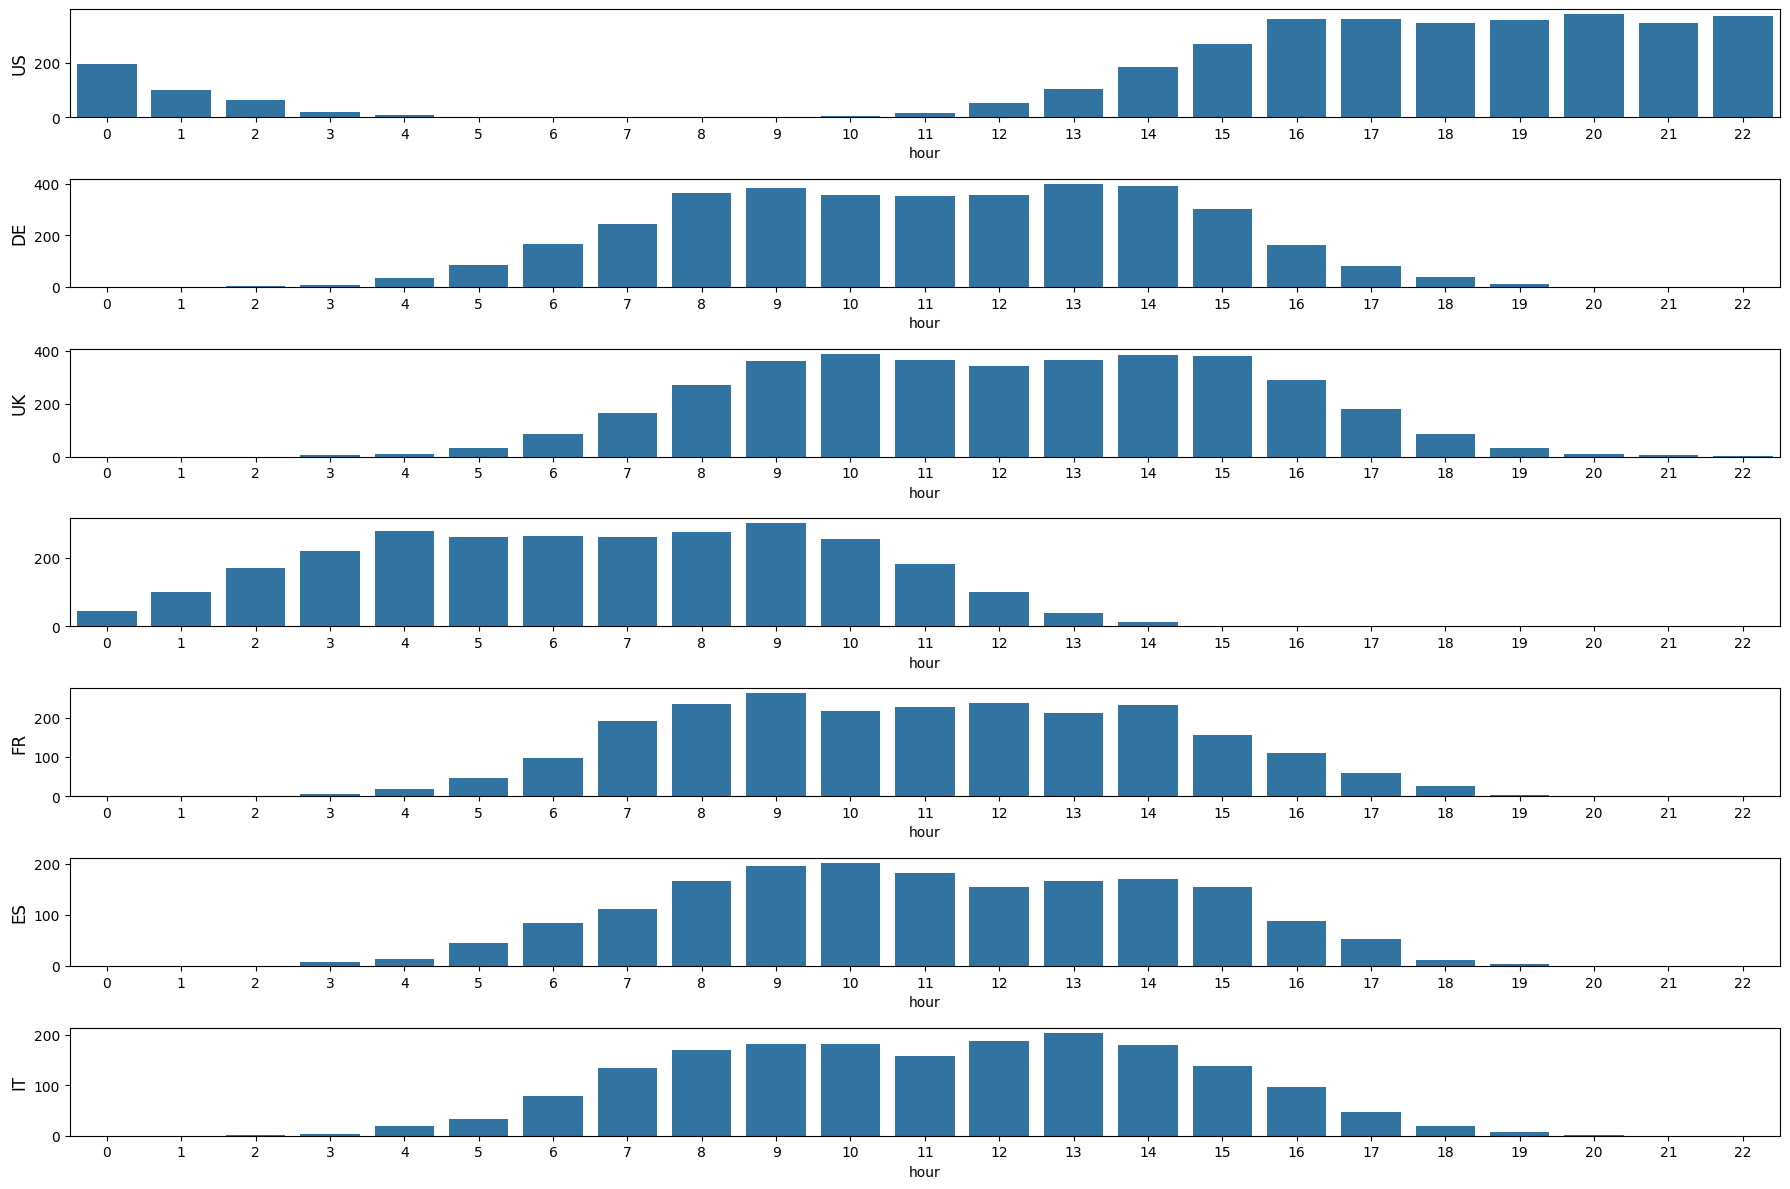

In [208]:
# visualization
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

从上图可以看出，对于未知国家，其搜索高峰时间与美国相差约 12 小时，与欧洲相差约 5 小时。根据每个国家的地理位置，似乎这个缺失的国家位于亚洲。可能的国家包括中国和日本。

# 关联城市

这个问题涉及到分析城市搜索数据，以找出在用户的同一会话中哪些城市经常一起被搜索。这可以帮助理解用户的旅行偏好或计划，比如哪些城市是常被同时考虑的旅行目的地。这样的分析对于市场营销策略、推荐系统或增强用户体验都是有益的。

具体来说，目标是确定对于给定的一个城市，用户在同一搜索会话中还搜索了哪些其他城市。这需要我们从数据中提取城市组合的模式，并计算每个城市对的共现频率。

In [209]:
# extract search time information
data['hour'] = data['unix_timestamp'].apply(lambda x: x.hour)

创建一个矩阵，用来计算城市之间的相似度：

In [210]:
# find unique cities
city_pair = data['cities'].apply(lambda x: x.split(', '))

index = 0
maps = {}
city_list = []
for item in city_pair:
    for city in item:
        if city not in maps:
            maps[city] = index
            index += 1
            city_list.append(city)
            
print('Unique cities:\t', len(city_list))

Unique cities:	 87


In [213]:
# calculate matrix similarity
pair_matrix = np.zeros((87, 87))

for item in city_pair:
    if len(item) == 1:
        continue
    for i in range(len(item) - 1):
        index1 = maps[item[i]]
        for j in range(i + 1, len(item)):
            index2 = maps[item[j]]
            pair_matrix[index1, index2] += 1
            pair_matrix[index2, index1] += 1

In [214]:
# create dataframe
df_similarity = pd.DataFrame(pair_matrix, index=city_list, columns=city_list)
df_similarity.head()

,San Jose CA,Montreal QC,New York NY,Quebec QC,Chicago IL,Toronto ON,Houston TX,Los Angeles CA,San Diego CA,Santa Ana CA,...,Norfolk VA,Atlanta GA,Charlotte NC,Raleigh NC,Lincoln NE,Omaha NE,Kansas City MO,Birmingham AL,Minneapolis MN,Memphis TN
San Jose CA,0.0,17.0,40.0,0.0,12.0,25.0,7.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Montreal QC,17.0,0.0,339.0,111.0,101.0,254.0,77.0,154.0,18.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New York NY,40.0,339.0,0.0,7.0,260.0,427.0,172.0,318.0,62.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quebec QC,0.0,111.0,7.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicago IL,12.0,101.0,260.0,0.0,0.0,145.0,74.0,116.0,20.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,12.0,0.0


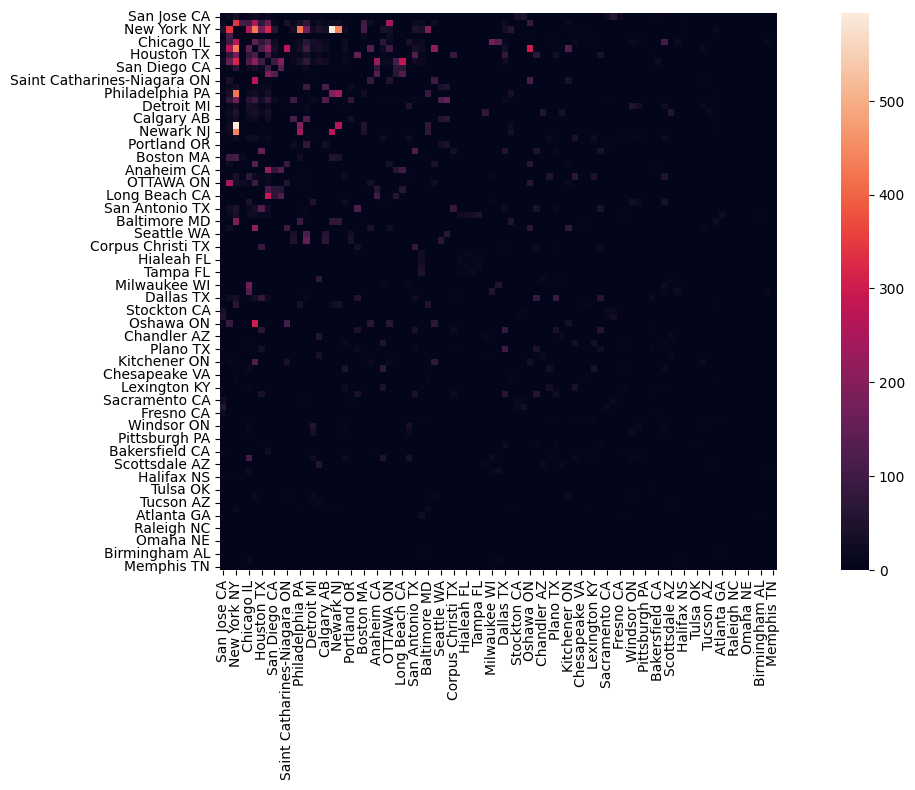

In [215]:
# visualization
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_similarity, ax=ax)
ax.axis('image')
plt.tight_layout()
plt.show()

获得结果：

In [216]:
# get result
result = df_similarity.apply(np.argmax, axis=0).reset_index()
result = result.rename(columns={'index': 'city', 0: 'most similar'})
result

,city,most similar
0,San Jose CA,61
1,Montreal QC,2
2,New York NY,17
3,Quebec QC,1
4,Chicago IL,2
...,...,...
82,Omaha NE,4
83,Kansas City MO,44
84,Birmingham AL,31
85,Minneapolis MN,4


# 用户分组

用户可以分为两个组：假想旅行用户和真实旅行用户。

针对这个问题，我们需要设计一个算法，将用户的搜索会话分为两类：高购买意向和低购买意向。这里的基本假设是，搜索地理位置相近的城市的用户具有更高的购买意向，而搜索地理位置相距甚远的城市的用户则更多只是在幻想度假。

In [217]:
def search_distance(cities):
    cities = cities.split(', ')
    
    if len(cities) == 1:
        return 0  # user only search one city, distance 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i]
        for j in range(i + 1, len(cities)):
            city2 = cities[j]
            distance += df_similarity.loc[city1, city2]
            
    return distance / len(cities)

# calculate distance
data['distance'] = data['cities'].apply(search_distance)

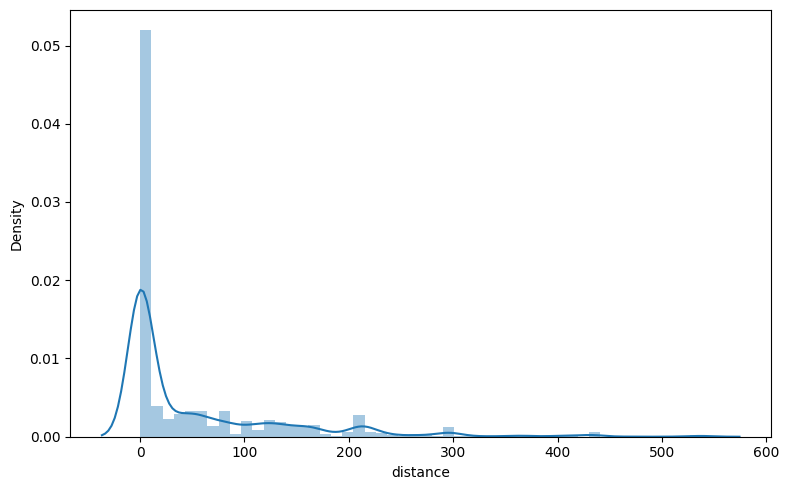

In [219]:
# visualization
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

还有一个方法是使用地图服务API，可以使用像Google Maps, Bing Maps或Mapbox等服务提供的距离计算API。这些API通常可以直接返回两个地点之间的路线距离（实际行驶距离）和直线距离。

这是一个代码框架：

```python
import googlemaps

def calculate_distance(origin, destination, api_key):
    gmaps = googlemaps.Client(key=api_key)
    result = gmaps.distance_matrix(origin, destination, mode='driving')
    distance = result['rows'][0]['elements'][0]['distance']['text']
    return distance

api_key = 'YOUR_API_KEY_HERE'
origin = "New York, NY"
destination = "Los Angeles, CA"
distance = calculate_distance(origin, destination, api_key)
print(f"Driving distance: {distance}")
```

但是，这个需要Google的API，而且需要计算的数据有些多，需要使用user_id和session_id，查看同一个user在同一个session_id中搜索过的cities，然后使用google map api来计算一下他们之间的距离，然后算一个总距离，最后进行可视化，从而判断threshold。

# 使用额外的数据信息

GeoNames 提供全球地理位置的数据集，包括城市、国家、地区等信息。GeoNames 提供的城市数据库包含每个国家的所有城市的名称、经纬度、人口等信息。

下载地址为：https://download.geonames.org/export/dump/